In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12310.44it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from rl import RNDIntrinsicReward
import numpy as np

# RND Trial (Can be skipped)

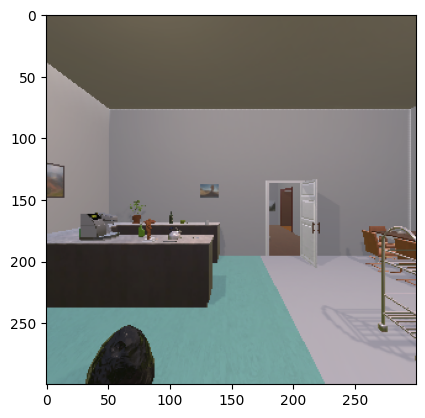

In [4]:
rnd_try = RNDIntrinsicReward()
event = controller.step(
    action="TeleportFull",
    x=spawn["x"],
    y=spawn["y"],
    z=spawn["z"],
    rotation={"x": 0, "y": 90, "z": 0},
    horizon=0,
    standing=True
)
plt.imshow(event.frame)

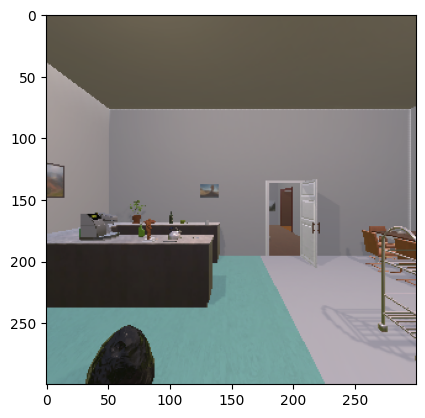

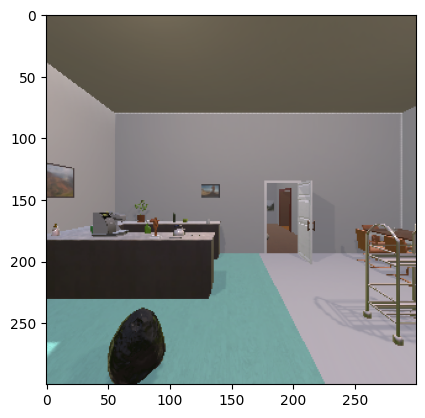

[0.6022416548479056, 0.5854337095586398, 0.5707490719054661, 0.5568277886396936, 0.5440669863510298] 0.5504761112339458


In [5]:
event = controller.step("Pass")

rws = []
for i in range(5):
    rw1 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
    rws.append(rw1)
plt.imshow(event.frame)
plt.show()
event = controller.step("MoveBack")
plt.imshow(event.frame)
plt.show()
rw3 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
print(rws, rw3)
# plt.imshow(event.frame.copy())

# Start Training

In [4]:
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [5]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, RNDIntrinsicEnv, ClipEnv, CLIPNovelty
from models import Actor, Critic, FrozenResNetEncoder
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [6]:
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            for t in range(1, EPISODE_STEPS + 1):
                obs_t = ppo.obs_from_event(event)  # (C,H,W)
                obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0).to(device=DEVICE)
                logits, value = ppo.act_and_value(obs_seq, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t)
                rewards.append(reward)
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done and np.random.rand() > 0.5:
                    event = teleport(controller)
                    env.reset()
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [7]:
rnd_reward = RNDIntrinsicReward()
rnd_intrinsic_env = RNDIntrinsicEnv(rnd_reward)
rnd_actor_critic = ActorCritic()
ppo = PPO(0.08)
buf, rewards = train(controller, "clip_actor_critic_checkpoint_lstm.pt", ppo, rnd_intrinsic_env, rnd_actor_critic, 1)

TypeError: ActorCritic.__init__() missing 3 required positional arguments: 'encoder', 'actor', and 'critic'

# Final Inference

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from cons import ACTIONS

n = 120
n_row = 8
positions = []

plt.figure(figsize=(n // n_row, n_row))
event = teleport(controller)

episode_seq = []
for t in range(1, n + 1):
    obs_t = ppo.obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
    logits, value = ppo.act_and_value(obs_seq)
    dist = torch.distributions.Categorical(logits=logits)
    print(logits.shape)
    print(torch.softmax(logits, dim=0))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0, 4)

    event, reward = rnd_intrinsic_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metadata
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}", fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


TypeError: act_and_value() missing 1 required positional argument: 'actor_critic'

<Figure size 1500x800 with 0 Axes>

In [18]:
controller.stop()

# CLIP Novelty - Transformer

In [8]:
ENTROPY_COEF = 0.02

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = Actor(FEAT_DIM, NUM_ACTIONS, n_layers=4)
critic = Critic(FEAT_DIM, n_layers=4)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


TypeError: CLIPNovelty.__init__() missing 1 required positional argument: 'device'

In [9]:
from rl import load_actor_critic

load_actor_critic(clip_actor_critic,  "data/clip_actor_critic_checkpoint_big_transformer.pt")

[🔁] Actor-Critic checkpoint loaded from data/clip_actor_critic_checkpoint_big_transformer.pt


[PPO] Epoch 0: Loss=8.9882, Policy=0.0027, Value=18.0127
[PPO] Epoch 10: Loss=6.0774, Policy=-0.0119, Value=12.2204
[PPO] Epoch 20: Loss=4.7426, Policy=-0.0198, Value=9.5664
[PPO] Epoch 30: Loss=4.1422, Policy=-0.0348, Value=8.3953
Approx KL Learned: 0.0310344435274601
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 1/10 — steps: 1024


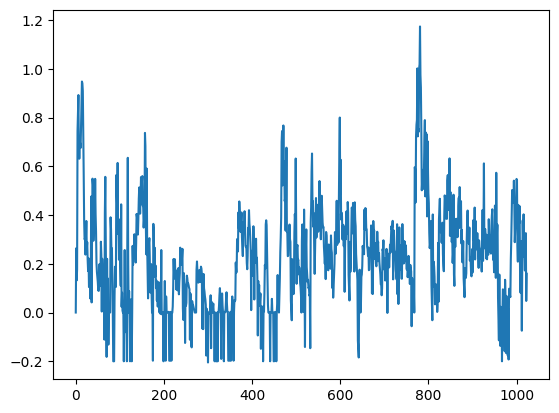

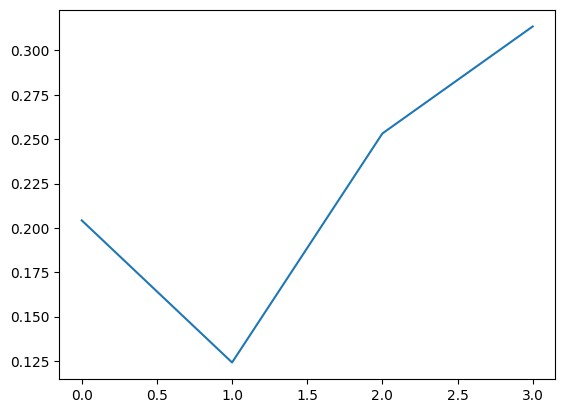

[PPO] Epoch 0: Loss=8.1471, Policy=0.0013, Value=16.3337
[PPO] Epoch 10: Loss=5.5293, Policy=-0.0099, Value=11.1197
[PPO] Epoch 20: Loss=3.6642, Policy=-0.0216, Value=7.4129
[PPO] Epoch 30: Loss=3.0697, Policy=-0.0287, Value=6.2385
Approx KL Learned: 0.03669428825378418
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 2/10 — steps: 1024


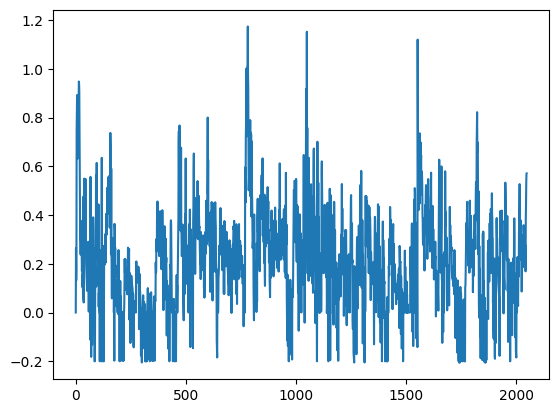

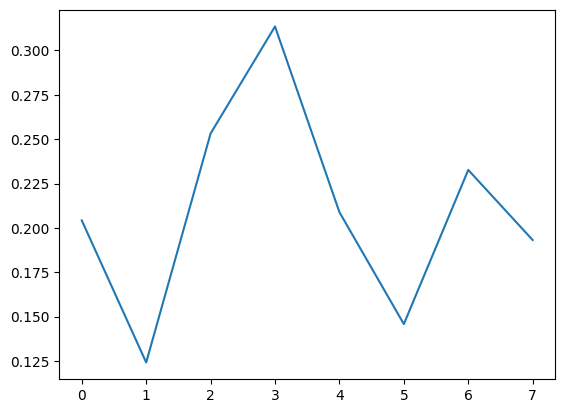

[PPO] Epoch 0: Loss=7.9557, Policy=0.0082, Value=15.9365
[PPO] Epoch 10: Loss=5.6694, Policy=-0.0137, Value=11.4084
[PPO] Epoch 20: Loss=5.2300, Policy=-0.0373, Value=10.5766
[PPO] Epoch 30: Loss=4.7402, Policy=-0.0582, Value=9.6382
Approx KL Learned: 0.02083108201622963
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 3/10 — steps: 1024


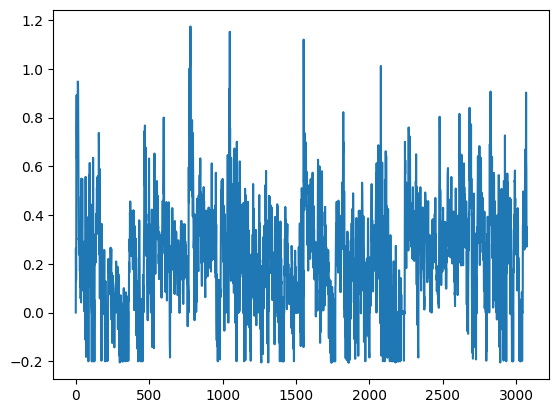

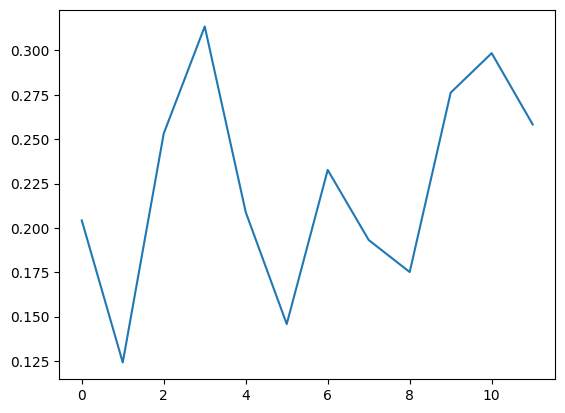

[PPO] Epoch 0: Loss=11.9494, Policy=0.0057, Value=23.9287
[PPO] Epoch 10: Loss=10.8788, Policy=-0.0130, Value=21.8252
[PPO] Epoch 20: Loss=10.0734, Policy=-0.0302, Value=20.2486
[PPO] Epoch 30: Loss=9.3567, Policy=-0.0492, Value=18.8529
Approx KL Learned: 0.03039025515317917
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 4/10 — steps: 1024


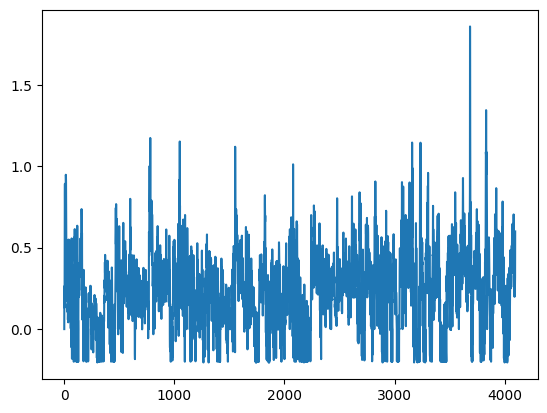

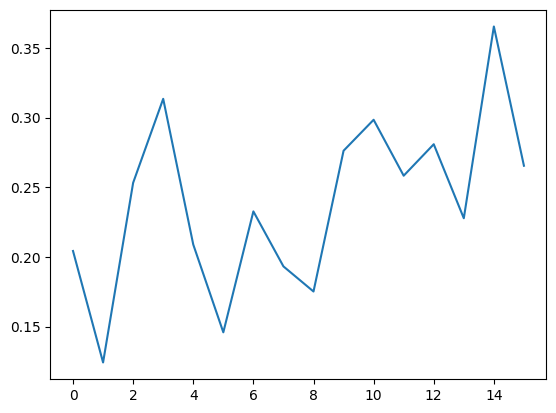

[PPO] Epoch 0: Loss=7.2570, Policy=0.0057, Value=14.5424
[PPO] Epoch 10: Loss=5.6291, Policy=-0.0160, Value=11.3306
[PPO] Epoch 20: Loss=5.0060, Policy=-0.0348, Value=10.1219
[PPO] Epoch 30: Loss=4.4519, Policy=-0.0515, Value=9.0460
Approx KL Learned: 0.04491709917783737
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 5/10 — steps: 1024


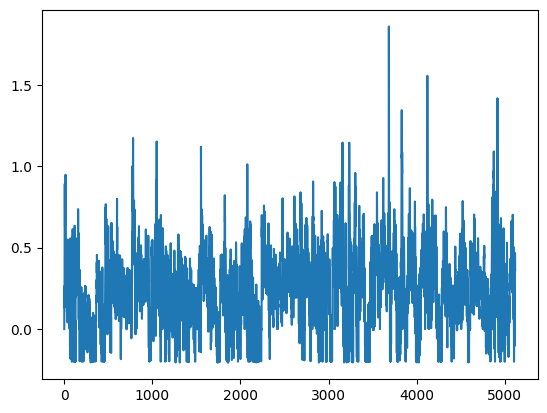

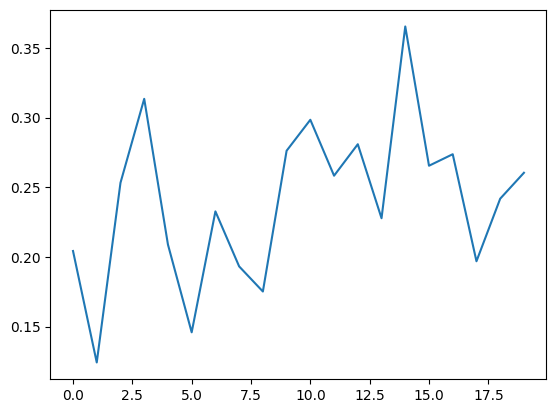

[PPO] Epoch 0: Loss=11.1775, Policy=0.0109, Value=22.3739
[PPO] Epoch 10: Loss=6.9902, Policy=0.0032, Value=14.0144
[PPO] Epoch 20: Loss=6.8345, Policy=-0.0120, Value=13.7336
[PPO] Epoch 30: Loss=5.6590, Policy=-0.0271, Value=11.4131
Approx KL Learned: 0.028822455555200577
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 6/10 — steps: 1024


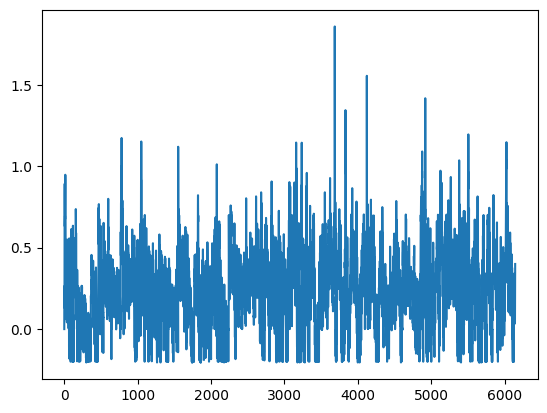

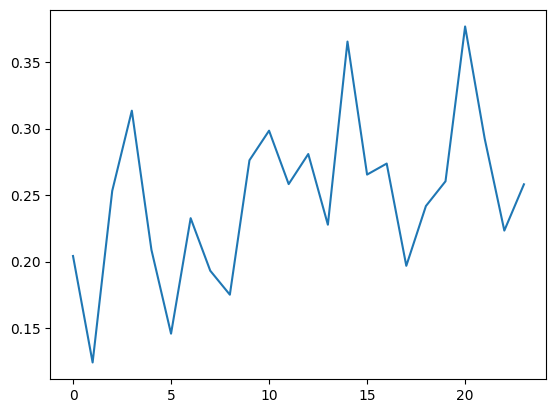

[PPO] Epoch 0: Loss=11.9605, Policy=0.0066, Value=23.9468
[PPO] Epoch 10: Loss=11.5621, Policy=0.0052, Value=23.1526
[PPO] Epoch 20: Loss=10.6342, Policy=-0.0220, Value=21.3517
[PPO] Epoch 30: Loss=9.7521, Policy=-0.0408, Value=19.6249
Approx KL Learned: 0.03741486370563507
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 7/10 — steps: 1024


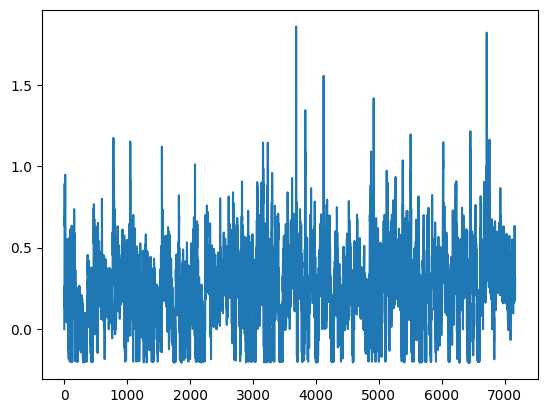

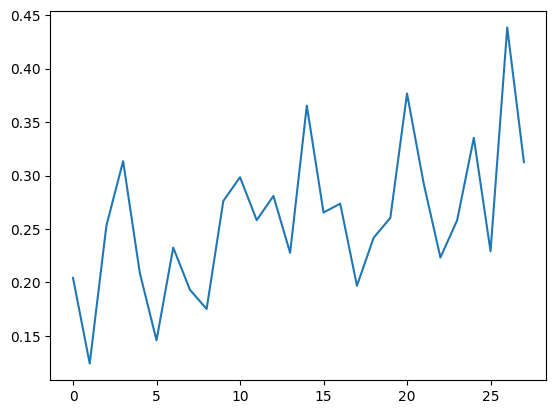

[PPO] Epoch 0: Loss=12.9955, Policy=0.0237, Value=25.9810
[PPO] Epoch 10: Loss=9.9297, Policy=-0.0000, Value=19.8966
[PPO] Epoch 20: Loss=8.9848, Policy=-0.0286, Value=18.0646
[PPO] Epoch 30: Loss=6.9357, Policy=-0.0482, Value=14.0043
Approx KL Learned: 0.024885931983590126
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 8/10 — steps: 1024


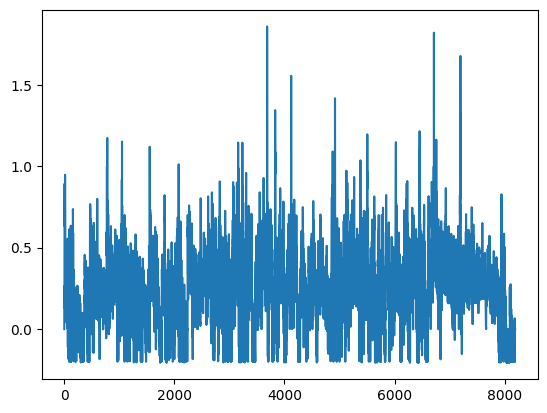

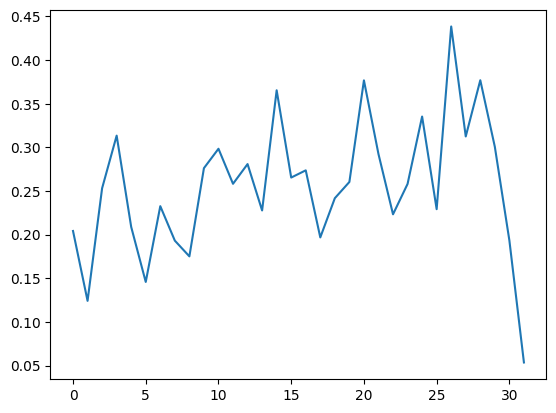

[PPO] Epoch 0: Loss=11.9717, Policy=0.0173, Value=23.9466
[PPO] Epoch 10: Loss=5.8622, Policy=-0.0103, Value=11.7835
[PPO] Epoch 20: Loss=4.8882, Policy=-0.0210, Value=9.8570
[PPO] Epoch 30: Loss=6.0631, Policy=-0.0342, Value=12.2335
Approx KL Learned: 0.03603410720825195
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 9/10 — steps: 1024


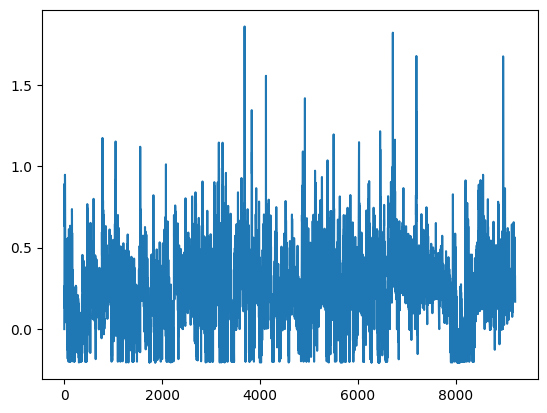

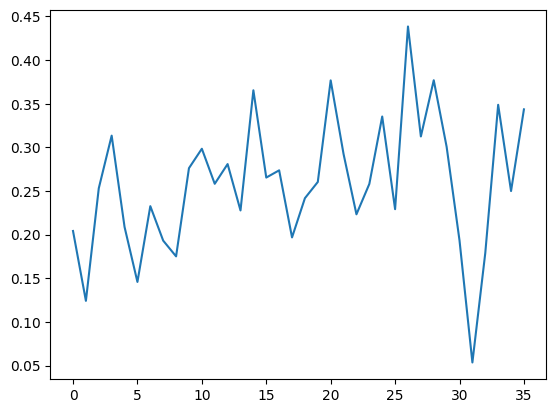

[PPO] Epoch 0: Loss=6.5548, Policy=0.0152, Value=13.1174
[PPO] Epoch 10: Loss=4.4449, Policy=-0.0070, Value=8.9420
[PPO] Epoch 20: Loss=3.2433, Policy=-0.0281, Value=6.5800
[PPO] Epoch 30: Loss=2.9192, Policy=-0.0277, Value=5.9318
Approx KL Learned: 0.04268582910299301
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_lstm.pt
Update 10/10 — steps: 1024


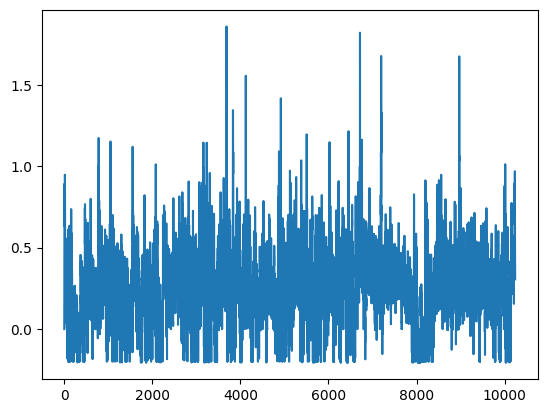

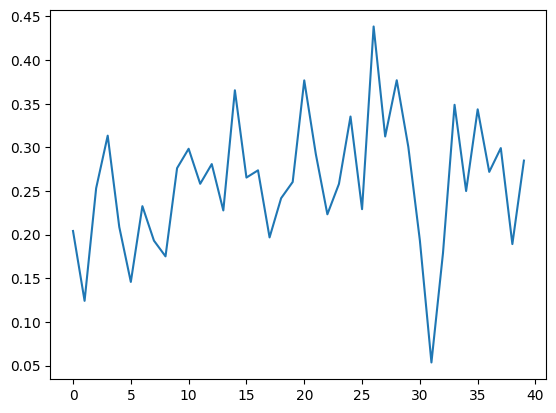

In [9]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_lstm.pt", ppo, clip_env, clip_actor_critic, 10)

# CLIP Novelty - LSTM

In [ ]:
from models import LSTMActor, LSTMCritic

In [ ]:
ENTROPY_COEF = 0.0

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = LSTMActor(FEAT_DIM, NUM_ACTIONS)
critic = LSTMCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)
# buf, rewards = train(controller, ppo, clip_env, clip_actor_critic, 20)

In [1]:
ENTROPY_COEF = 0.04
buf, rewards = train(controller, clip_env, clip_actor_critic, 1)

NameError: name 'train' is not defined

In [162]:
save_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_clip_embed.pt")

[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_clip_embed.pt


In [ ]:
house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [187]:
load_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_high_entropy.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from clip_actor_critic_checkpoint_high_entropy.pt


Init position {'x': 3.8863887786865234, 'y': 0.9009993672370911, 'z': 0.2852471172809601}


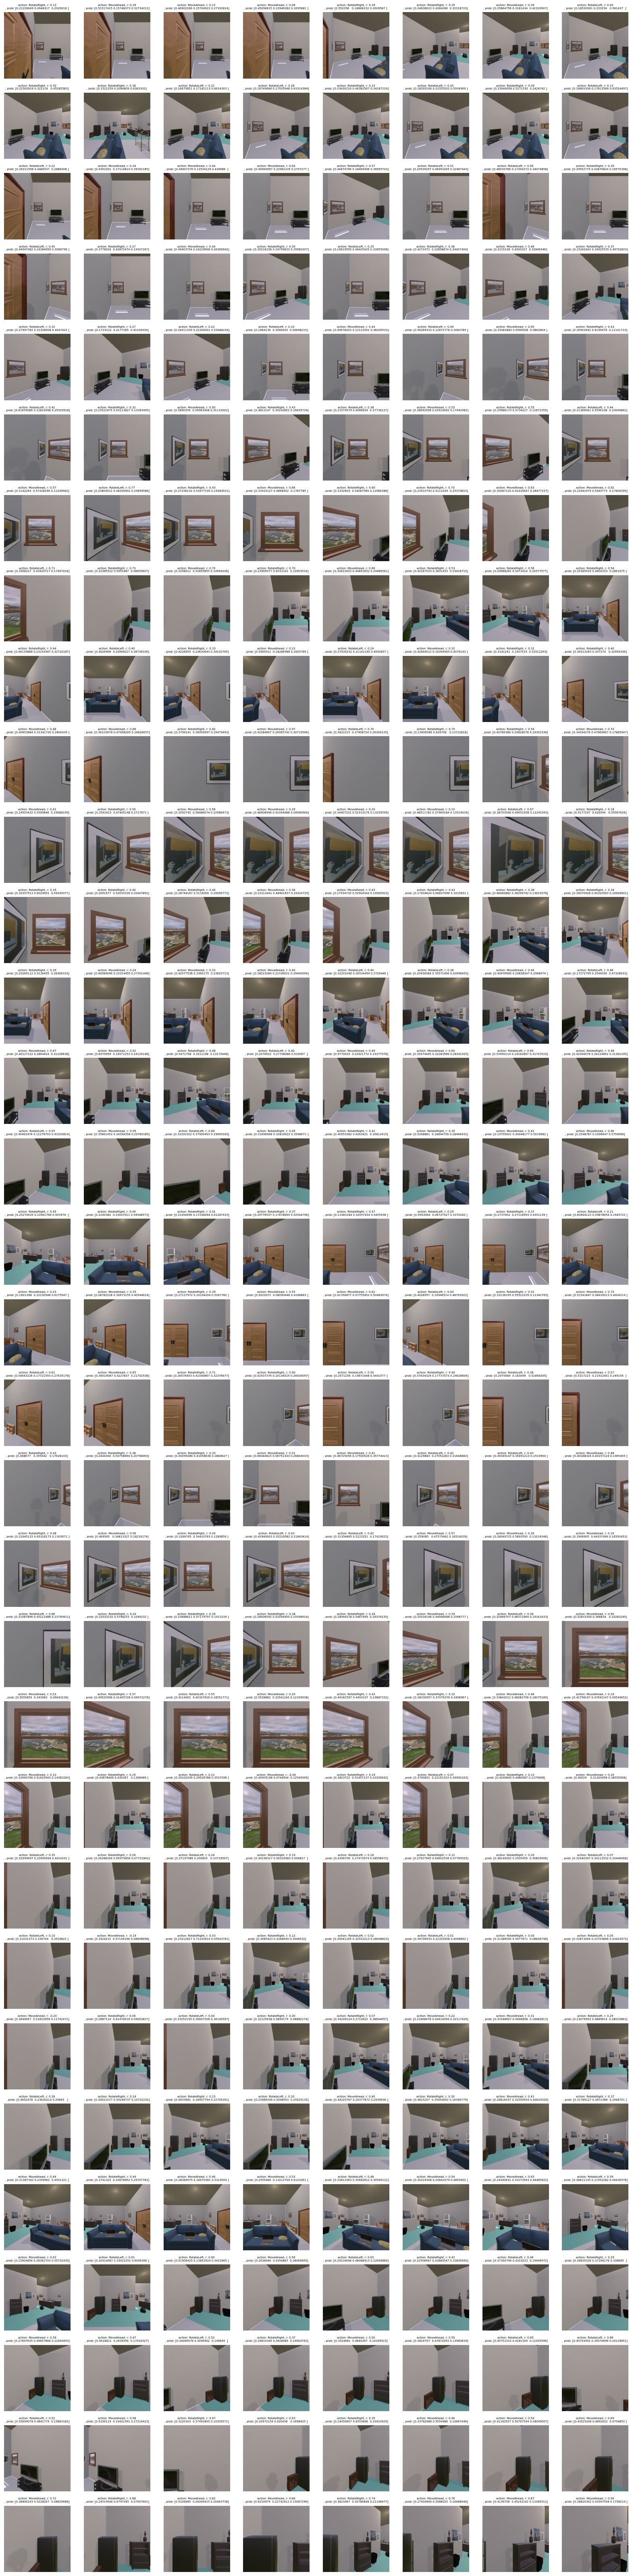

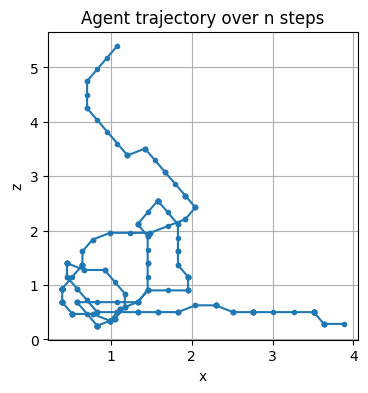

In [18]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

n = 256
n_row = 32
positions = []

plt.figure(figsize=(n // n_row * 2, n_row * 2))
# event = teleport(controller, {'x': 9.792665481567383, 'y': 0.9009993672370911, 'z': 2.9606857299804688})
# event = teleport(controller)
print("Init position", event.metadata["agent"]["position"])
episode_seq = deque(maxlen=EPISODE_STEPS)
for t in range(1, n + 1):
    obs_t = ppo.obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(list(episode_seq) + [obs_t], dim=0).unsqueeze(0)
    logits, value = ppo.act_and_value(obs_seq, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0,4)

    event, reward = clip_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metada
    # ta
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob: " + str(torch.softmax(logits, dim=0).cpu().numpy()), fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


In [948]:
novelty.reset()

img_buffer = []

tensor([0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716,
        0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716,
        0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008, 0.2163, 0.1621, 0.1206,
        0.0386, 0.0000, 0.2642, 0.3384, 0.3403, 0.3716, 0.3354, 0.3110, 0.3008,
        0.2163, 0.1621, 0.2163, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.1206,
        0.1621, 0.2163, 0.3008, 0.2163, 0.1621, 0.1206, 0.0386, 0.0000, 0.2642,
        0.3384, 0.2642], device='cuda:0'

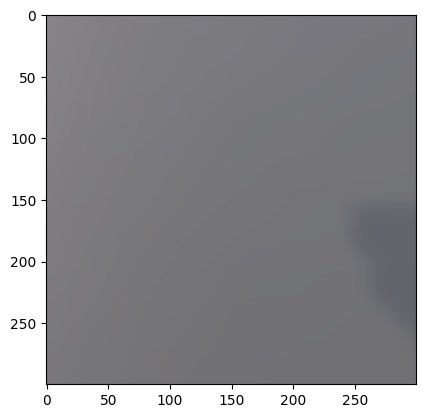

In [1075]:
# teleport(controller, {'x': 8.790684700012207, 'y': 0.9009993672370911, 'z': 2.460493564605713})

action_idx = 2
event = controller.step("RotateRight")

plt.imshow(event.frame)

novelty = clip_env.clip_novelty


frame_np = event.frame
# action_idx = np.random.randint(0,4)
img = Image.fromarray(frame_np)
img_t = novelty.preprocess(img).unsqueeze(0).to(novelty.device)
emb = novelty.model.encode_image(img_t)
emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize to unit sphere
if len(novelty.buffer) == 0:
    novelty.buffer.append(emb)
    img_buffer.append(event.frame)
else:
#     return 0.0  # no past frames to compare yet
    past = torch.cat(list(novelty.buffer), dim=0)  # (N, D)
    sim = F.cosine_similarity(emb, past)        # (N,)
    print((1 - sim), 10 * torch.clamp(sim - 0.98, min=0.0)**2)
    reward = torch.mean((1 - sim) - 10 * torch.clamp(sim - 0.98, min=0.0)**2)
    novelty.buffer.append(emb)
    img_buffer.append(event.frame)
    print(sim)
    print(reward)

In [ ]:
Wall vs wall 0.9614


(<matplotlib.collections.PathCollection at 0x7fe3d001b550>,
 tensor(0.0137, device='cuda:0', dtype=torch.float16, grad_fn=<VarBackward0>),
 tensor(0.7705, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

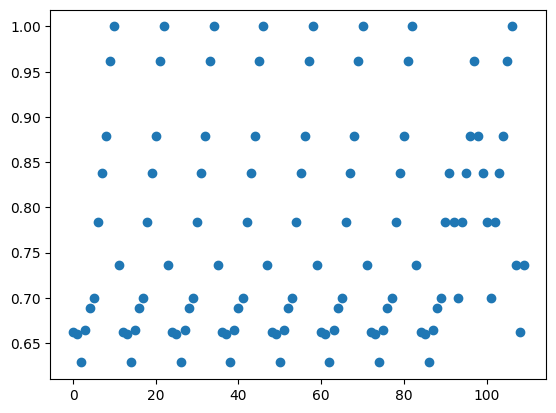

In [1076]:
plt.scatter(np.arange(len(sim)), sim.detach().cpu()), sim.var(), sim.mean()

(<matplotlib.collections.PathCollection at 0x7fe5487c1490>,
 tensor(0.0191, device='cuda:0', dtype=torch.float16, grad_fn=<VarBackward0>),
 tensor(0.7900, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>))

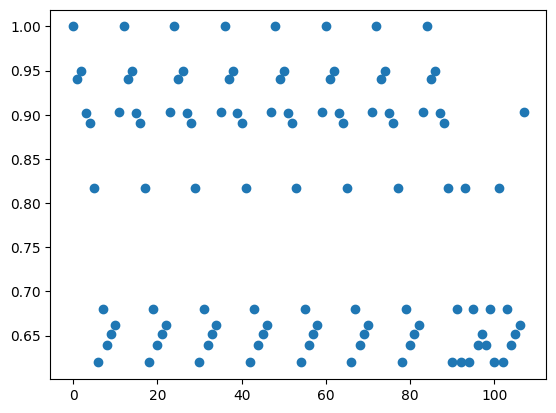

In [1073]:
plt.scatter(np.arange(len(sim)), sim.detach().cpu()), sim.var(), sim.mean()

In [17]:
controller.stop()